# Advanced Lane Finding

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Calibrating camera

The following block performs camera calibration using OpenCV framework and an image directory, supplied with the task

camera_cal/calibration1.jpg
camera_cal/calibration10.jpg
camera_cal/calibration11.jpg
camera_cal/calibration12.jpg
camera_cal/calibration13.jpg
camera_cal/calibration14.jpg
camera_cal/calibration15.jpg
Just FYI the shape of calibration15.jpg is (721, 1281) does not match previous images shape (720, 1280)
camera_cal/calibration16.jpg
camera_cal/calibration17.jpg
camera_cal/calibration18.jpg
camera_cal/calibration19.jpg
camera_cal/calibration2.jpg
camera_cal/calibration20.jpg
camera_cal/calibration3.jpg
camera_cal/calibration4.jpg
camera_cal/calibration5.jpg
camera_cal/calibration6.jpg
camera_cal/calibration7.jpg
Just FYI the shape of calibration7.jpg is (721, 1281) does not match previous images shape (720, 1280)
camera_cal/calibration8.jpg
camera_cal/calibration9.jpg
Camera matrix: [[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Lens distortion coefficients: [[ -2.41017956

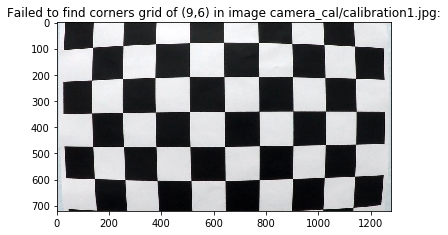

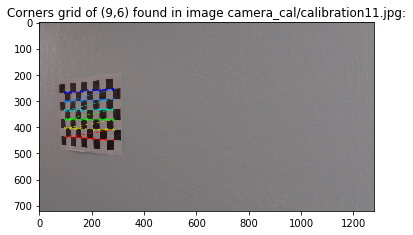

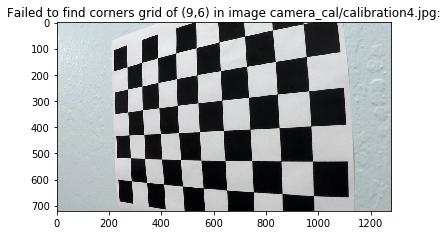

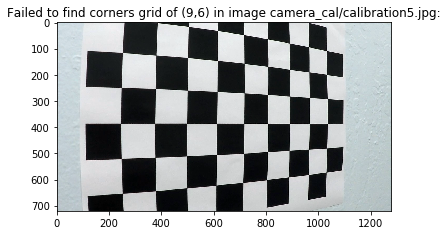

In [2]:
# number of chessboard joints in each direction
NX = 9
NY = 6
CAM_CAL_DIR = "camera_cal"

def extractCornersOne(path, bPlot=False):
    print(path)
    img = cv2.imread(path)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (NX, NY), None)

    if not ret:
        corners = None
        fig = plt.figure()
        plt.title('Failed to find corners grid of ({},{}) in image {}:'.format(NX, NY, path))
        plt.imshow(img)
    elif bPlot:
        cv2.drawChessboardCorners(img, (NX, NY), corners, ret)
        fig = plt.figure()
        plt.title('Corners grid of ({},{}) found in image {}:'.format(NX, NY, path))
        plt.imshow(img)
        
    return corners, gray.shape

def extractCornersDir(path):
    corners = []
    i = 0
    shapeAll = None
    for img in os.listdir(path):
        cornersImg, shape = extractCornersOne(CAM_CAL_DIR + '/' + img, i == 1)
        if cornersImg is None:
            continue

        if shapeAll is None:
            shapeAll = shape
        elif shapeAll != shape:
            print('Just FYI the shape of {} is {} does not match previous images shape {}'.format(img, shape, shapeAll))
            
        corners.append(cornersImg)
        i += 1
    return corners, shapeAll

def calibrateCameraUsingImages(path):
    # create fixed representation of chessboard in the object space
    ptsObj = np.zeros((NX*NY, 3), np.float32)
    ptsObj[:,:2] = np.mgrid[0:NX, 0:NY].T.reshape(-1, 2)

    ptsImg, imgShape = extractCornersDir(path)
    
    #make sure there is a copy of object space for every image space feature sets
    ptsObj = [ptsObj] * len(ptsImg)
    
    #ptsObj = np.asarray(ptsObj)
    #print(ptsObj.shape)
    #print()

    #ptsImg = np.asarray(ptsImg)
    #print(ptsImg.shape)
    #print()

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(ptsObj, ptsImg, imgShape[::-1], None, None)
    return mtx, dist

mtx, dist = calibrateCameraUsingImages(CAM_CAL_DIR)
print('Camera matrix: {}'.format(mtx))
print('Lens distortion coefficients: {}'.format(dist))

Checking how the most warped image looks after undistortion:

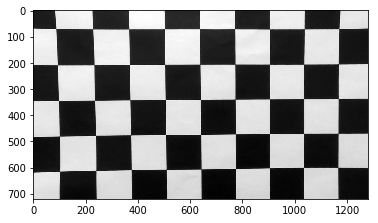

In [3]:
_img = cv2.imread(CAM_CAL_DIR + '/calibration1.jpg')
_img = cv2.cvtColor(_img, cv2.COLOR_BGR2GRAY)
_img = cv2.undistort(_img, mtx, dist)
plt.imshow(_img, cmap='gray')